In [1]:
# IMPORTS

# basic
import os

# data analysis
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# tensorflow
import tensorflow as tf

In [2]:
# config
train_folder = './train_v2/'
test_folder = './test_v2/'

## Load CSV

In [3]:
# reading train csv
original_df = pd.read_csv('train_ship_segmentations_v2.csv')
original_df

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...,...
231718,fffedbb6b.jpg,NaN
231719,ffff2aa57.jpg,NaN
231720,ffff6e525.jpg,NaN
231721,ffffc50b4.jpg,NaN


In [4]:
# grouping rows with same photo
df_grouped = pd.DataFrame(original_df.groupby('ImageId')['EncodedPixels']
                          .apply(lambda x: None if type(x.values[0]) == float else ' '.join(x.astype(str))))
df_grouped

,EncodedPixels
ImageId,
00003e153.jpg,None
0001124c7.jpg,None
000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
0001b1832.jpg,None
...,...
fffedbb6b.jpg,None
ffff2aa57.jpg,None
ffff6e525.jpg,None


## Integrity check

In [15]:
def load_img(path):
    return tf.keras.utils.load_img(train_folder+path)

def load_img_test(path):
    return tf.keras.utils.load_img(test_folder+path)

In [26]:
# check if images are loading successfully and have same size (768*768*3)
for index, row in df_grouped.iterrows():
    img = None
    try:
        img = np.array(load_img(index))
    except:
        print(f'Can\'t load image with path: {train_folder + index}')
        continue
    if img.shape != (768,768,3):
        print(f'Incorrect size of image with path: {train_folder + index}')

Can't load image with path: ./train_v2/6384c3e78.jpg


In [29]:
# check the same for test images
for index, row in pd.read_csv('sample_submission_v2.csv', index_col='ImageId').iterrows():
    img = None
    try:
        img = np.array(load_img_test(index))
    except:
        print(f'Can\'t load image with path: {test_folder + index}')
        continue
    if img.shape != (768,768,3):
        print(f'Incorrect size of image with path: {test_folder + index}')

In [31]:
# remove corrupted image
df_grouped = df_grouped.drop('6384c3e78.jpg')

# Analysis

In [5]:
print('Photos with ships:', '%.2f' % ((1 - (df_grouped.EncodedPixels.isna().sum() / 
                                            len(df_grouped.EncodedPixels))) * 100), '%')

Photos with ships: 22.10 %


<b>Note:</b> Imbalanced dataset

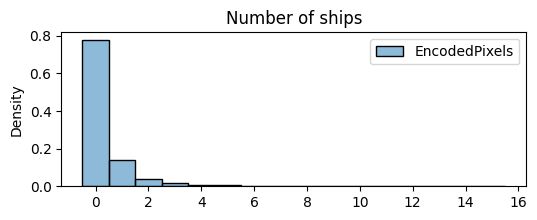

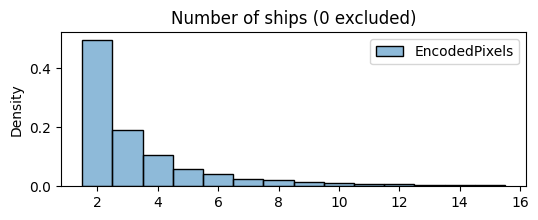

EncodedPixels,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,150000,27104,7674,2954,1622,925,657,406,318,243,168,144,124,75,76,66


In [64]:
# get distribution of number of ships per picture
temp_df = original_df.groupby('ImageId').count()

# plot
plt.figure(figsize=(6,2))
plt.title('Number of ships')
sns.histplot(temp_df, discrete=True, stat='density')
plt.show()

# plot only with ships
plt.figure(figsize=(6,2))
plt.title('Number of ships (0 excluded)')
sns.histplot(temp_df.loc[temp_df.EncodedPixels > 1], discrete=True, stat='density')
plt.show()

# plot heatmap
display(pd.DataFrame(temp_df.groupby('EncodedPixels').value_counts()).T)

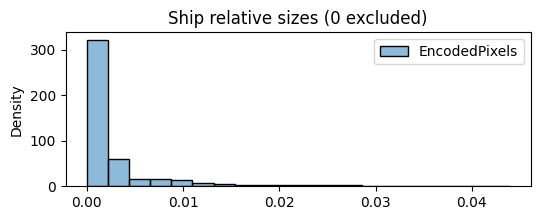

Bigger than 1%: 7.31 %


In [73]:
# get distribution of ship sizes relative to photo size
temp_df = pd.DataFrame(original_df.EncodedPixels.astype(str).map(lambda x: 0 if x == 'nan' 
                                                    else np.array(x.split(' ')[1::2], dtype='int64').sum() / (768*768)))
temp_df = pd.DataFrame(temp_df.loc[temp_df.EncodedPixels > 0])

# plot
plt.figure(figsize=(6,2))
plt.title('Ship relative sizes (0 excluded)')
sns.histplot(temp_df, stat='density', bins=20)
plt.show()

print('Bigger than 1%:', '%.2f' % (temp_df.loc[temp_df.EncodedPixels > 0.01].count() / len(temp_df) * 100).values[0], '%')

<b>Notes:</b>
- most ships take less that 1% of total photo size
- only 7.3% of ships takes more than 1% of a photo size

## Image observation

In [5]:
def load_img(path):
    return tf.keras.utils.load_img(f'./train/{path}')

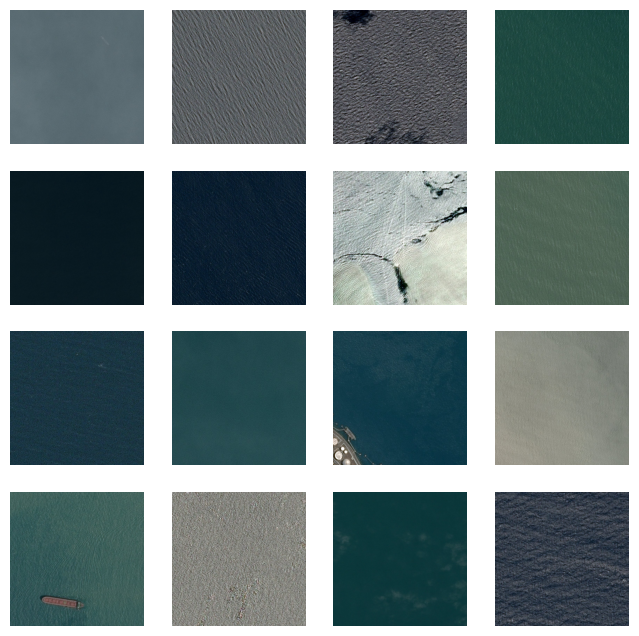

In [44]:
# show sample photos from dataset

# get 16 random photos
sample_imgs = [load_img(df_grouped.sample(1).index[0]) for _ in range(16)]  

# plot
plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.axis('off')
    plt.imshow(sample_imgs[i])
plt.show()

<b>Found objects:</b> 
- sea
- ships
- coastes/lands
- industrial objects
- clouds
- underwater sands
- cities
- harbors

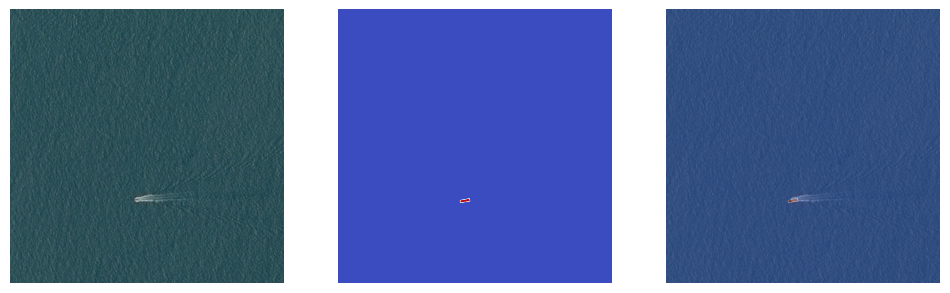

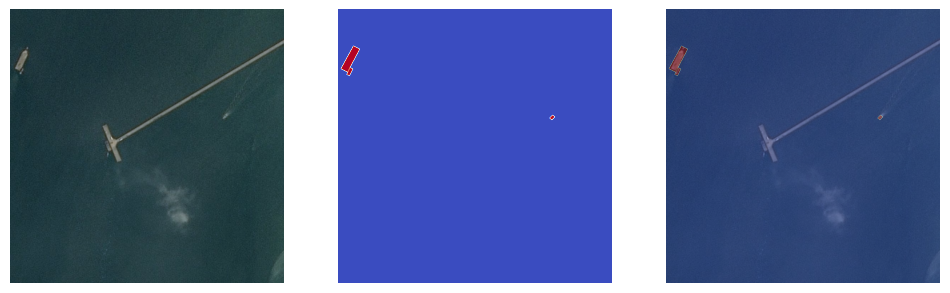

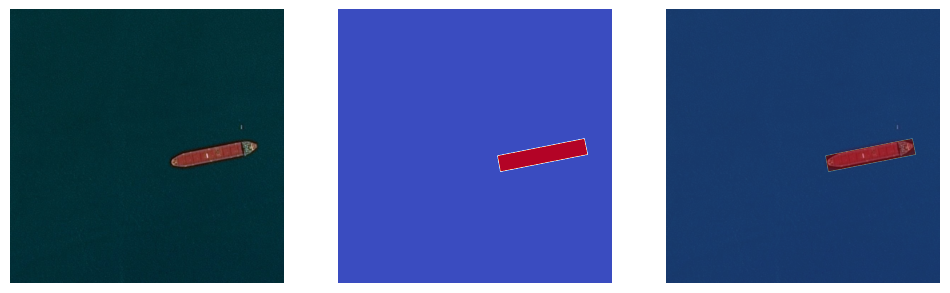

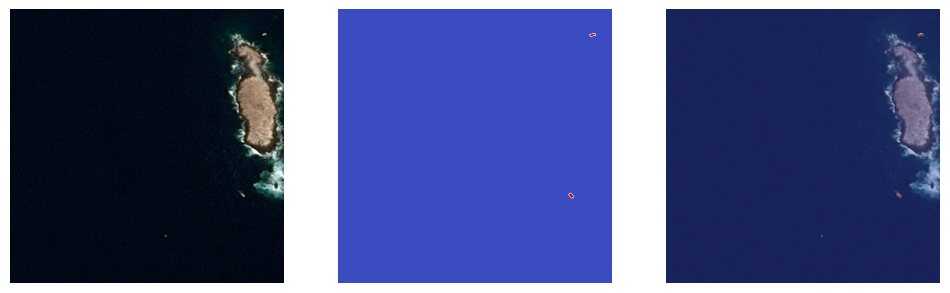

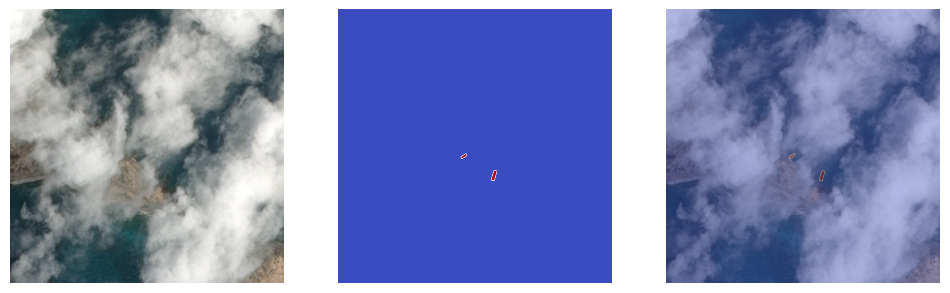

In [77]:
# show segmentation samples

for _ in range(5):
    # get random photo
    segmented_row = df_grouped.loc[df_grouped.EncodedPixels.notnull()].sample(1)
    original_photo = load_img(segmented_row.index[0])

    # create segmented photo from EncodedPixels
    segmented_photo = np.zeros((original_photo.size[0] * original_photo.size[1]))  # 1D array for black image
    RLE = [int(x) for x in segmented_row.EncodedPixels.values[0].split(' ')]
    for idx in range(0, len(RLE), 2):  # change segmented pixels
        segmented_photo[ RLE[idx] : RLE[idx]+RLE[idx+1] ] = 1
    segmented_photo = np.transpose(np.reshape(segmented_photo, (original_photo.size[0], original_photo.size[1], 1)), (1,0,2))

    # plot
    plt.figure(figsize=(12,6))
    # original photo
    plt.subplot(131)
    plt.axis('off')
    plt.imshow(original_photo)
    # segmentation
    plt.subplot(132)
    plt.axis('off')
    plt.imshow(segmented_photo, cmap='coolwarm')
    # multiplication
    plt.subplot(133)
    plt.axis('off')
    plt.imshow(original_photo)
    plt.imshow(segmented_photo, cmap='coolwarm', alpha=0.4)
    plt.show()

<b>Notes:</b>
- segmentation of every ship is represented as a rectangle
- segmentations are a bit bigger than actual ship
- if ships are very close to each other their segmentations doesn't cross over 

## Results
- corrupted image in train set with name '6384c3e78.jpg'
- dataset is imbalanced: only 22% of images contains ships and more than 90% of ships takes less than 1% of an image space (sparce segmentation space)
- images contain such objects: sea, ships, coastes/lands, industrial objects, clouds, underwater sands, cities, harbors
- segmentations represented as rectangles and they doesn't intersect for different ships